In [1]:
# data download and preprocessing

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from pathlib import Path

# using metadata path
metadata_path = r"C:\Users\dixonsal\OneDrive\Desktop\CU-Anschutz\Year 1\CPBS\Intro to Big Data in Biomedical Sciences\Assignments\Assignment #1\GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt"

# load the metadata
metadata = pd.read_csv(metadata_path, sep="\t", low_memory=False)

In [3]:
# get top 10 tissues by sample count
top_tissues = metadata['SMTS'].value_counts().head(10).index.tolist()

# filtering metadata to only include those tissues!
metadata_top = metadata[metadata['SMTS'].isin(top_tissues)]

# confirming the counts
print(metadata_top['SMTS'].value_counts())

SMTS
Brain             8035
Blood             4717
Skin              4469
Esophagus         3394
Blood Vessel      3286
Adipose Tissue    2461
Muscle            2352
Heart             2138
Colon             2085
Thyroid           2033
Name: count, dtype: int64


In [7]:
import pandas as pd
expression_path = r"C:\Users\dixonsal\OneDrive\Desktop\CU-Anschutz\Year 1\CPBS\Intro to Big Data in Biomedical Sciences\Assignments\Assignment #1\GTEx_Analysis_v10_RNASeQCv2.4.2_gene_tpm.gct\GTEx_Analysis_2022-06-06_v10_RNASeQCv2.4.2_gene_tpm_non_lcm.gct"

# Load expression data (skip top 2 header rows)
expression = pd.read_csv(expression_path, sep="\t", skiprows=2, nrows=10000)

# print(expression.head()) to check expression data 

# removing 'name' and 'description' columns to compute variance
expression_num = expression.drop(columns=['Name', 'Description'])

# calculating variance for each gene
gene_variances = expression_num.var(axis=1)

# get indices of top 5000 most variable genes
top_genes_idx = gene_variances.nlargest(5000).index

# subsetting expression data to keep only those genes
expression_filtered = expression.iloc[top_genes_idx]

In [8]:
from sklearn.preprocessing import StandardScaler

# dropping 'name' and 'description' to scale only numeric data
expression_data_only = expression_filtered.drop(columns=['Name', 'Description'])

# transpose to samples as rows, genes as columns 
expression_T = expression_data_only.T

# standardize!
scaler = StandardScaler()
expression_scaled = scaler.fit_transform(expression_T)

# converting back to df
import pandas as pd
expression_scaled_df = pd.DataFrame(expression_scaled, index=expression_T.index, columns=expression_T.columns)

In [9]:
# cluster analysis

In [10]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns

# standardize data matrix (samples x genes)
X = expression_scaled_df.values

# true labels = tissues for each sample
sample_ids = expression_scaled_df.index
sample_labels = metadata.set_index('SAMPID').loc[sample_ids]['SMTS'].values

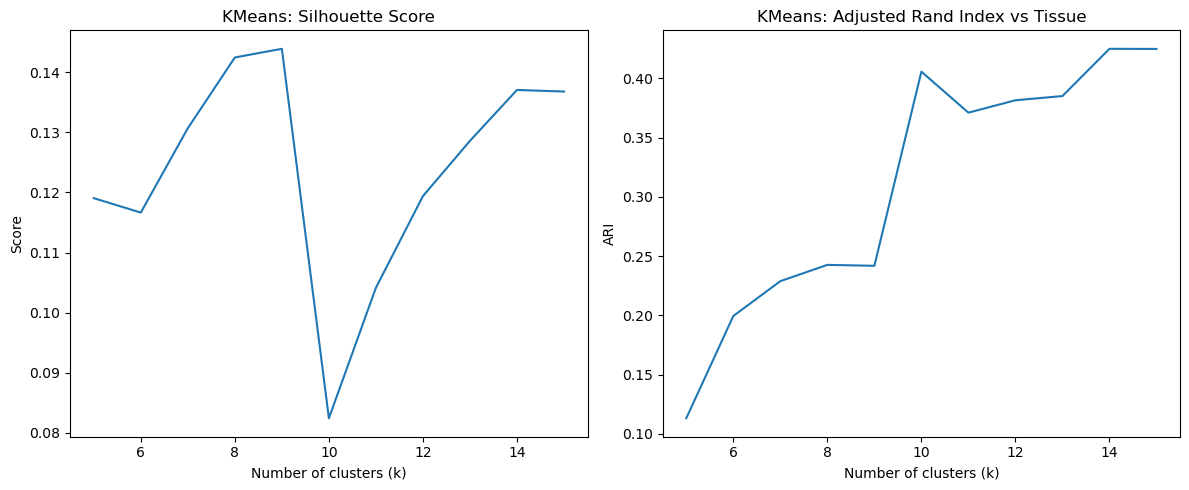

In [12]:
k_range = range(5, 16)
sil_scores_kmeans = []
ari_scores_kmeans = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    
    # Internal quality
    sil = silhouette_score(X, cluster_labels)
    sil_scores_kmeans.append(sil)

    # External agreement with tissue
    ari = adjusted_rand_score(sample_labels, cluster_labels)
    ari_scores_kmeans.append(ari)

# Plot scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.lineplot(x=k_range, y=sil_scores_kmeans)
plt.title("KMeans: Silhouette Score")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Score")

plt.subplot(1, 2, 2)
sns.lineplot(x=k_range, y=ari_scores_kmeans)
plt.title("KMeans: Adjusted Rand Index vs Tissue")
plt.xlabel("Number of clusters (k)")
plt.ylabel("ARI")
plt.tight_layout()
plt.show()

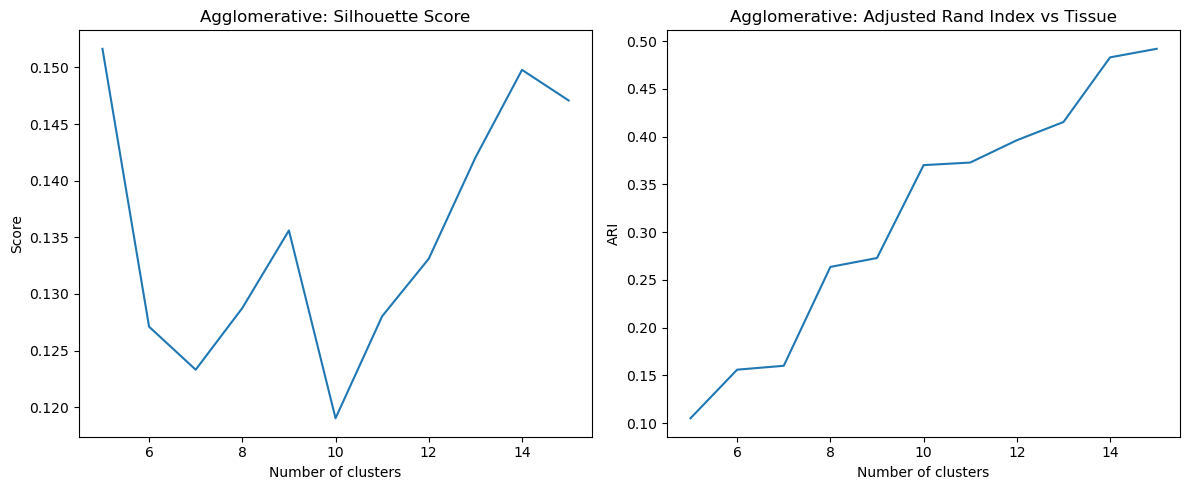

In [14]:
sil_scores_agg = []
ari_scores_agg = []

for k in k_range:
    agg = AgglomerativeClustering(n_clusters=k)
    cluster_labels = agg.fit_predict(X)
    
    sil = silhouette_score(X, cluster_labels)
    sil_scores_agg.append(sil)

    ari = adjusted_rand_score(sample_labels, cluster_labels)
    ari_scores_agg.append(ari)

# Plot scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.lineplot(x=k_range, y=sil_scores_agg)
plt.title("Agglomerative: Silhouette Score")
plt.xlabel("Number of clusters")
plt.ylabel("Score")

plt.subplot(1, 2, 2)
sns.lineplot(x=k_range, y=ari_scores_agg)
plt.title("Agglomerative: Adjusted Rand Index vs Tissue")
plt.xlabel("Number of clusters")
plt.ylabel("ARI")
plt.tight_layout()
plt.show()

In [27]:
# !pip install umap-learn
# !pip install --upgrade umap-learn

In [41]:
# cluster evaluation & interpretation
# !pip uninstall scikit-learn -y
# !pip install scikit-learn --force-reinstall --no-cache-dir

In [35]:
from sklearn.cluster import KMeans

optimal_k = 10  # or whatever k you chose from earlier analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

In [34]:
# mean expression by cluster

# convert to DataFrame (add gene names back in)
expression_data = pd.DataFrame(X, columns=expression.columns[2:2 + X.shape[1]])
expression_data['cluster'] = kmeans_labels

# calculate cluster means
cluster_means = expression_data.groupby('cluster').mean()

# get top genes per cluster (relative expression)
top_genes_per_cluster = {}
for cluster in cluster_means.index:
    top_genes = cluster_means.loc[cluster].sort_values(ascending=False).head(10)
    top_genes_per_cluster[cluster] = top_genes

# display top genes!
for cluster, genes in top_genes_per_cluster.items():
    print(f"\nTop genes for cluster {cluster}:\n{genes}")


Top genes for cluster 0:
GTEX-11GS4-0011-R7a-SM-GJ3RK    2.693848
GTEX-1192X-0426-SM-5GIEE        2.669217
GTEX-11TUW-0011-R5b-SM-5BC6Q    2.664426
GTEX-11GS4-0826-SM-5986J        2.662414
GTEX-11DYG-0426-SM-5987J        2.649407
GTEX-11EMC-0011-R8b-SM-DO91Z    2.639917
GTEX-11PRG-1426-SM-GJ3RU        2.639721
GTEX-1128S-2826-SM-5N9DI        2.625382
GTEX-111YS-1426-SM-5GID8        2.608461
GTEX-11GSP-0011-R3a-SM-9QEGF    2.606984
Name: 0, dtype: float64

Top genes for cluster 1:
GTEX-131XE-1526-SM-5KM1A    1.141233
GTEX-139T8-0126-SM-5K7XZ    1.065769
GTEX-11GS4-0626-SM-5A5LC    1.025188
GTEX-1117F-0626-SM-5N9CS    1.016713
GTEX-113IC-0008-SM-5QGRF    1.014481
GTEX-11P81-0326-SM-5HL6B    0.974836
GTEX-14C39-2726-SM-5PNXN    0.960105
GTEX-11TT1-2426-SM-5EQMK    0.951701
GTEX-12ZZY-3126-SM-5DUX3    0.942636
GTEX-13PVQ-1226-SM-5IJDC    0.923001
Name: 1, dtype: float64

Top genes for cluster 2:
GTEX-11P82-0426-SM-5HL5D        7.026994
GTEX-117YW-2426-SM-5Q5AE        6.994108
GTEX-11OC5-0

C:\Users\dixonsal\AppData\Local\Temp\ipykernel_2780\3455765270.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['cluster'] = kmeans_labels


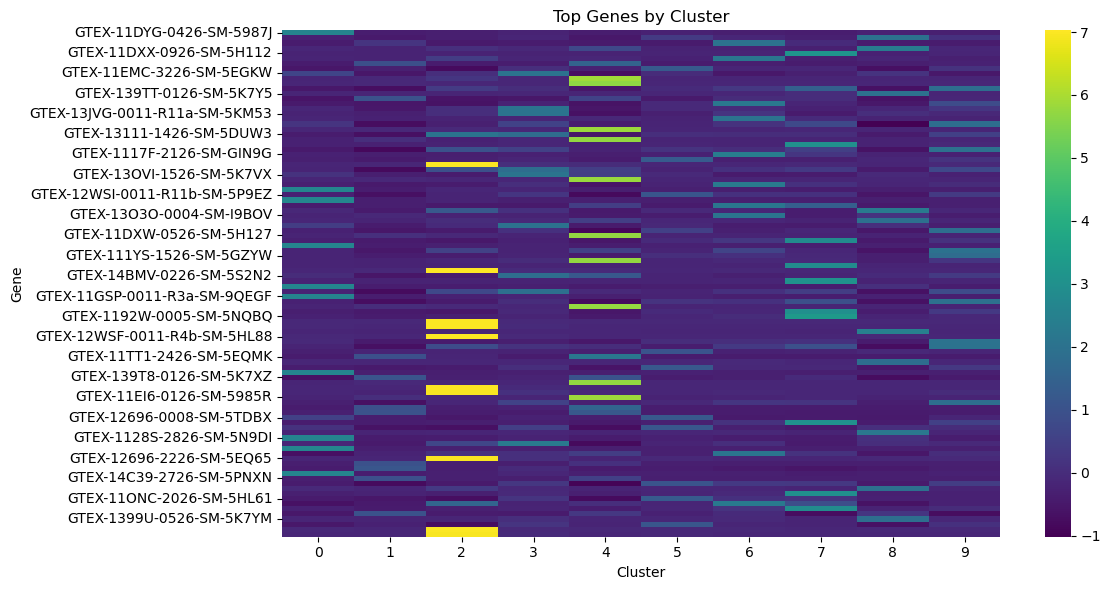

In [36]:
# visualize the top genes
import seaborn as sns
import matplotlib.pyplot as plt

# selecting genes from all clusters
selected_genes = list(set([gene for genes in top_genes_per_cluster.values() for gene in genes.index]))

# subsetting data
subset = expression_data[selected_genes]
subset['cluster'] = kmeans_labels

# computing cluster means
heatmap_data = subset.groupby('cluster').mean()

# plot!
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data.T, cmap='viridis')
plt.title("Top Genes by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()